# Исследуем данные train

In [1]:
import pandas as pd
train = pd.read_csv('train.csv.zip', sep=',', index_col=0,
                       dtype = {'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 
                                'content_type_id': 'int8', 'task_container_id': 'int16', 'user_answer': 'int8', 
                                'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                                'prior_question_had_explanation': 'boolean'
                               }
                      )
display(train.head())

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


In [13]:
print(f'У нас есть {train.user_id.nunique()} уникальных пользователей в наборе данных')

У нас есть 393656 уникальных пользователей в наборе данных


In [14]:
#Content_type_id = 0 означает, что был задан вопрос. 
#1 означает, что пользователь смотрел лекцию
train.content_type_id.value_counts()

0    99271300
1     1959032
Name: content_type_id, dtype: int64

In [16]:
print(f'У нас представлены {train.content_id.nunique()} индефицированных кода в наборе данных, из которых {train[train.content_type_id == False].content_id.nunique()} - вопросы.')


У нас представлены 13782 индефицированных кода в наборе данных, из которых 13523 - вопросы.


In [18]:
print(f'У нас есть {train.task_container_id.nunique()} уникальных групп вопросов или лекций.')

У нас есть 10000 уникальных групп вопросов или лекций.


In [19]:
#user_answer - вариант ответа, который выбрал ученик. 
#Всего вариантов может быть 4.
#В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

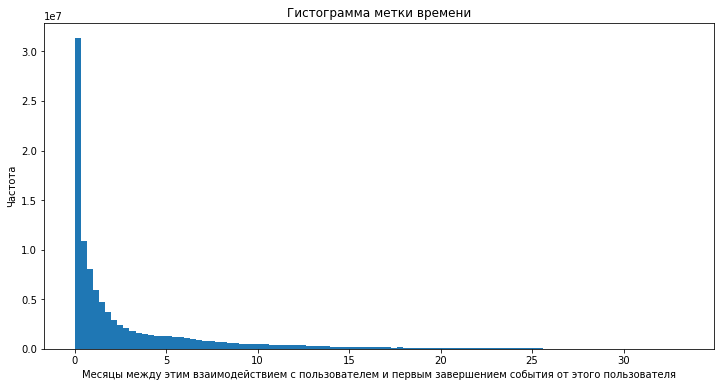

In [24]:
import matplotlib.pyplot as plt

ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Гистограмма метки времени")
plt.xticks(rotation=0)
plt.xlabel("Месяцы между этим взаимодействием с пользователем и первым завершением события от этого пользователя")
plt.ylabel("Частота")
plt.show()

Итак, timestamp - время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
Заметим, что самые активные ученики-это те, которые еще не так долго взаимодействуют с платформой.

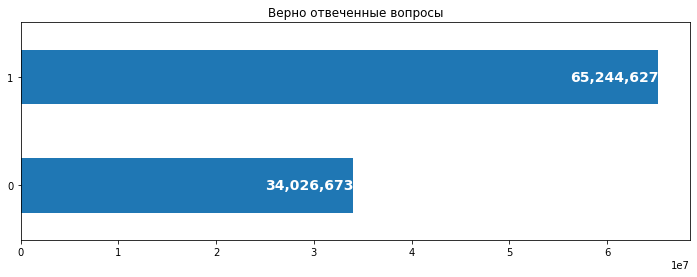

In [37]:
#Посмотрим в каком соотношений ученики ответили верно
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Верно отвеченные вопросы")
plt.xticks(rotation=0)
plt.show()


Как можно заметить, примерно на треть вопросов ответили неверно. 

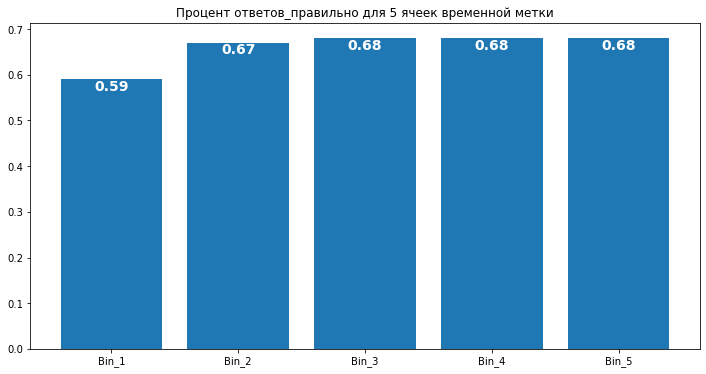

In [36]:
#Проверим зависимость между активностью студента на платформе
# и количеством верных ответов на поставленные вопросы

import matplotlib.pyplot as plt
import numpy as np

bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент ответов_правильно для 5 ячеек временной метки")
plt.xticks(rotation=0)
plt.show()

Получается, что пользователи, которые зарегистрировались относительно недавно, работают немного лучше,чем другие.

prior_question_had_explanation
False     9197826
True     89685560
<NA>       387914
Name: (answered_correctly, count), dtype: int64


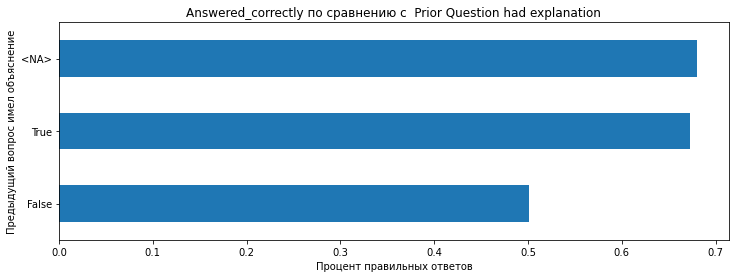

In [38]:
#Теперь проверим, влияет ли на ответ смотрел ли ученик объяснение
#и правильное решение на предыдущий вопрос.
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly по сравнению с  Prior Question had explanation")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Предыдущий вопрос имел объяснение")
plt.xticks(rotation=0)
plt.show()


Действительно, процент правильных ответов при условии,что студент посмотрел ответ на предыдущию задачу, выше. 

In [41]:
#prior_question_elapsed_time: (float32) среднее время в миллисекундах, которое ученику потребовалось, 
#чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. 
#Равен 0 для первой группы вопросов, заданной ученику.
#Посмотрим на среднее значение
pq = train[train.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly': ['count'], 'prior_question_elapsed_time': ['mean']})

pq


,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,34026673,25641.992188
1,65244627,25309.976562


Заметим, что среднее время примерно равно, соотвественно этот параметр нам не несет качественной информации.

In [48]:
user_percents = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'Максимальное количество вопросов на которые ответил пользователь {user_percents.Answers.max()}')

Максимальное количество вопросов на которые ответил пользователь 17609


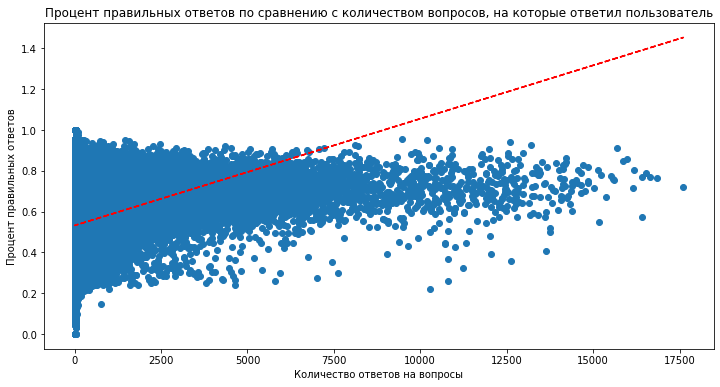

In [50]:
user_percent = user_percents.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percents.Answers
y = user_percents.Mean
plt.scatter(x, y, marker='o')
plt.title("Процент правильных ответов по сравнению с количеством вопросов, на которые ответил пользователь")
plt.xticks(rotation=0)
plt.xlabel("Количество ответов на вопросы")
plt.ylabel("Процент правильных ответов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()


Как видим, тенденция восходящая.

# Исследуем данные questions

In [3]:
import pandas as pd
questions = pd.read_csv('questions.csv', sep=',',
                        dtype = {'question_id': 'int16', 'bundle_id': 'int16', 'correct_answer': 'int8',
                                 'part': 'int8', 'tags': 'object'
                               })
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


Для удобства обозначим колонки:
question_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
bundle_id: код по которому вопросы объединяются в группы.
correct_answer: правильный ответ на вопрос.
part: один из семи типов вопросов TOEIC. Ниже будет краткое описание каждого
tags: один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы
сделать кластеризацию.


In [45]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [44]:
#уникальные значения для каждой колонки
unique_list_q = []
for col in questions.columns:
    item = (col, questions[col].nunique(), questions[col].dtype)
    unique_list_q.append(item)
unique_counts_q = pd.DataFrame(unique_list_q,
                               columns=['Column_Name', 'Num_Unique', 'Type']
                              ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_q)

,Column_Name,Num_Unique,Type
0,correct_answer,4,int8
1,part,7,int8
2,tags,1519,object
3,bundle_id,9765,int16
4,question_id,13523,int16


<AxesSubplot:>

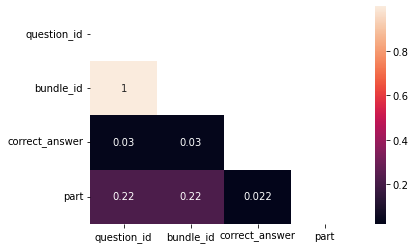

In [38]:
# Построим матрицу корреляций в привычном нам виде.
import seaborn as sns
matrix = np.triu(questions.corr())
sns.heatmap(questions.corr(), annot=True, mask=matrix)

Фичи question_id и bundle_id дублируют друг друга.

In [46]:
questions.shape

(13523, 5)

In [18]:
questions[['part','question_id']].groupby(['part'], as_index=False).count()

,part,question_id
0,1,992
1,2,1647
2,3,1562
3,4,1439
4,5,5511
5,6,1212
6,7,1160


Так, вопросы распределены относительно равномерно, кроме 5го раздела, которому посвящено больше всего заданий.

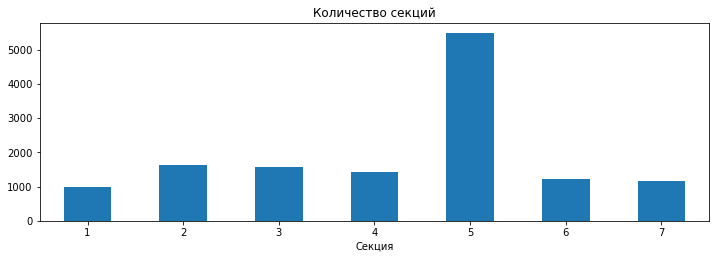

In [26]:

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby('part').count()['question_id'].plot.bar()
plt.title("Количество секций")
plt.xlabel("Секция")
plt.xticks(rotation=0)
plt.show()


# Исследуем данные lectures

In [34]:
lectures = pd.read_csv('lectures.csv', sep=',',
                      dtype = {'lecture_id': 'int16', 'tag': 'int16', 
                               'part': 'int8', 'type_of': 'object'})
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


In [35]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


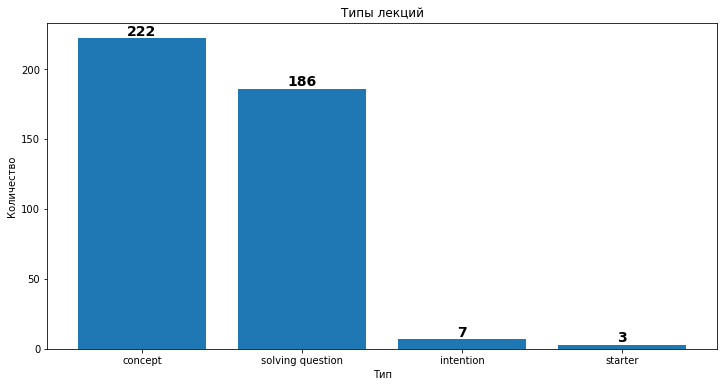

In [40]:
#Посмотрим распределение по type_of
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Типы лекций")
plt.xlabel("Тип")
plt.ylabel("Количество")
plt.xticks(rotation=0)
plt.show()

False    244050
True     149606
Name: Watches_lecture, dtype: int64


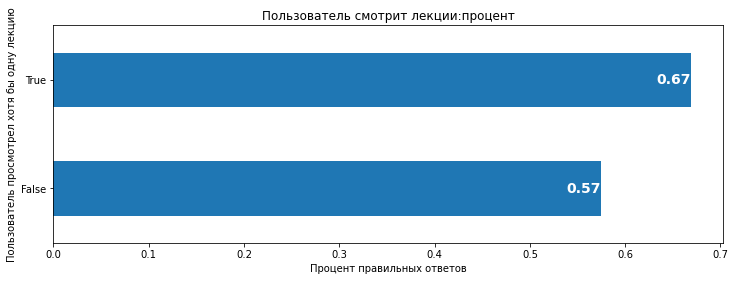

In [42]:
#Разберемся, помогают ли лекции в правильном решении
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)
watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Пользователь смотрит лекции:процент")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Пользователь просмотрел хотя бы одну лекцию")
plt.xticks(rotation=0)
plt.show()

Очевидно, что просмотр лекции помогает

<AxesSubplot:xlabel='part', ylabel='Count'>

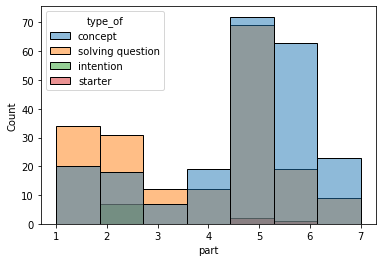

In [44]:
sns.histplot(data=lectures,x='part', hue = 'type_of', bins=7)

На последних трех разделах начинает преобладать теория.